In [17]:
#import necessary libs
import pandas as pd
import psycopg2
from pymongo import MongoClient
import logging
import matplotlib.pyplot as plt

#mongo configuration
MONGO_URI = "mongodb://localhost:27017/"
MONGO_DB = "aryan"
MONGO_COLLECTION = "projdb1"

#postgresql configuration
DB_HOST = 'localhost'
DB_PORT = '5433'
DB_NAME = 'projdb'
DB_USER = 'postgres'
DB_PASSWORD = '5920'

In [18]:
#read dataset and insert data into mongodb

file_path = "wfp_food_prices_ind.csv"
def insert_to_mongodb(file_path):
    client = MongoClient(MONGO_URI)
    db = client[MONGO_DB]
    collection = db[MONGO_COLLECTION]
    
    
    df = pd.read_csv(file_path)
    
    
    records = df.to_dict(orient='records')
    collection.insert_many(records)
    client.close()
    print(f"Inserted {len(records)} records into mongodb successfully.")

In [19]:
#extract data from mongodb
def extract_from_mongodb():
    client = MongoClient(MONGO_URI)
    db = client[MONGO_DB]
    collection = db[MONGO_COLLECTION]
    data = list(collection.find())
    client.close()

    if not data:
        raise ValueError("The mongodb collection is empty")
    
    return pd.DataFrame(data)

In [20]:
#data transformation (mapping, rename, drop, convert, normalize)
def transform_data(df):
    
    field_mapping = {
        "#date": "date",
        "#adm1+name": "admin1",
        "#adm2+name": "admin2",
        "#loc+market+name": "market",
        "#geo+lat": "latitude",
        "#geo+lon": "longitude",
        "#item+type": "category",
        "#item+name": "commodity",
        "#item+unit": "unit",
        "#item+price+flag": "priceflag",
        "#item+price+type": "pricetype",
        "#currency": "currency",
        "#value": "price",
        "#value+usd": "usdprice"
    }

    
    df.rename(columns=field_mapping, inplace=True)
        
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=['date'])  #drop rows with invalid dates
    else:
        raise KeyError("The 'date' column is missing after renaming.")
    
    if 'price' in df.columns:
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        df['price'].fillna(df['price'].median(), inplace=True)

    
    if 'commodity' in df.columns:
        df['commodity'] = df['commodity'].str.lower()
    if 'category' in df.columns:
        df['category'] = df['category'].str.lower()

    
    if '_id' in df.columns:
        df.drop('_id', axis=1, inplace=True)

    return df


In [21]:
#load data into postgreSQL
def create_connection():
    try:
        conn = psycopg2.connect(
            host=DB_HOST,
            port=DB_PORT,
            dbname=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD
        )
        return conn
    except Exception as e:
        logging.error(f"error connecting {e}", exc_info=True)
        return None


In [22]:
def create_table(table_name, columns):
    conn = create_connection()
    if conn is None:
        print("failed to connect to database")
        return

    try:
        cur = conn.cursor()
        column_definitions = ", ".join([f"{col} {dtype}" for col, dtype in columns.items()])
        create_table_query = f"""
        CREATE TABLE IF NOT EXISTS {table_name} ({column_definitions});
        """
        cur.execute(create_table_query)
        conn.commit()
    except Exception as e:
        logging.error(f"error creating table {e}", exc_info=True)
    finally:
        conn.close()


In [23]:
def insert_data(table_name, df):
    conn = create_connection()
    if conn is None:
        print("failed to connect to the database")
        return

    try:
        cur = conn.cursor()
        columns = ", ".join(df.columns)
        placeholders = ", ".join(["%s"] * len(df.columns))
        insert_query = f"""
        INSERT INTO {table_name} ({columns})
        VALUES ({placeholders});
        """
        for _, row in df.iterrows():
            cur.execute(insert_query, tuple(row))
        conn.commit()
    except Exception as e:
        logging.error(f"error inserting data {e}", exc_info=True)
    finally:
        conn.close()


In [24]:
#analysis and visualization
def load_data_from_db(table_name):
    conn = create_connection()
    if conn is None:
        print("failed to connect to the database")
        return None

    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql(query, conn)
    conn.close()
    return df


/var/folders/7h/7928v0ks54s0w22f6bdc9cyr0000gn/T/ipykernel_1584/2904411077.py:10: DtypeWarning: Columns (4,5,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Inserted 172018 records into mongodb successfully.


/var/folders/7h/7928v0ks54s0w22f6bdc9cyr0000gn/T/ipykernel_1584/23950094.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
/var/folders/7h/7928v0ks54s0w22f6bdc9cyr0000gn/T/ipykernel_1584/23950094.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = pd.to_numeric(df['price'], errors='coerce')
/var/folders/7h/7928v0ks54s0w22f6bdc9cyr0000gn/T/ipykernel_1584/23950094.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

               price       usdprice
count  172017.000000  172017.000000
mean       94.217050       1.453437
std       237.140712       4.057945
min         2.500000       0.056300
25%        26.000000       0.396100
50%        48.670000       0.723900
75%       101.300000       1.463600
max      4910.000000      88.778800


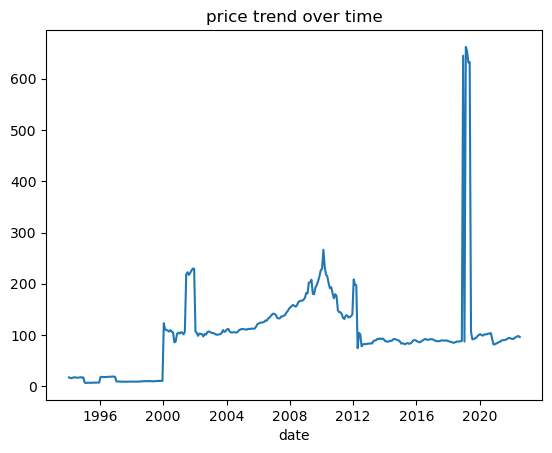

In [25]:

def load_data_from_db(table_name):
    conn = create_connection()
    if conn is None:
        print("failed to connect to the database")
        return None

    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql(query, conn)
    conn.close()
    return df


processed_table_name = "processed_food_prices"
processed_columns = {
    "date": "DATE",
    "admin1": "TEXT",
    "admin2": "TEXT",
    "market": "TEXT",
    "latitude": "TEXT",
    "longitude": "TEXT",
    "category": "TEXT",
    "commodity": "TEXT",
    "unit": "TEXT",
    "priceflag": "TEXT",
    "pricetype": "TEXT",
    "currency": "TEXT",
    "price": "FLOAT",
    "usdprice": "FLOAT"
}


file_path = "wfp_food_prices_ind.csv"


insert_to_mongodb(file_path)

#ETL
raw_data = extract_from_mongodb()
transformed_data = transform_data(raw_data)
create_table(processed_table_name, processed_columns)
insert_data(processed_table_name, transformed_data)


df_processed = load_data_from_db(processed_table_name)


print(df_processed.describe())
price_trend = df_processed.groupby('date')['price'].mean()
price_trend.plot(title="price trend over time")
plt.show()

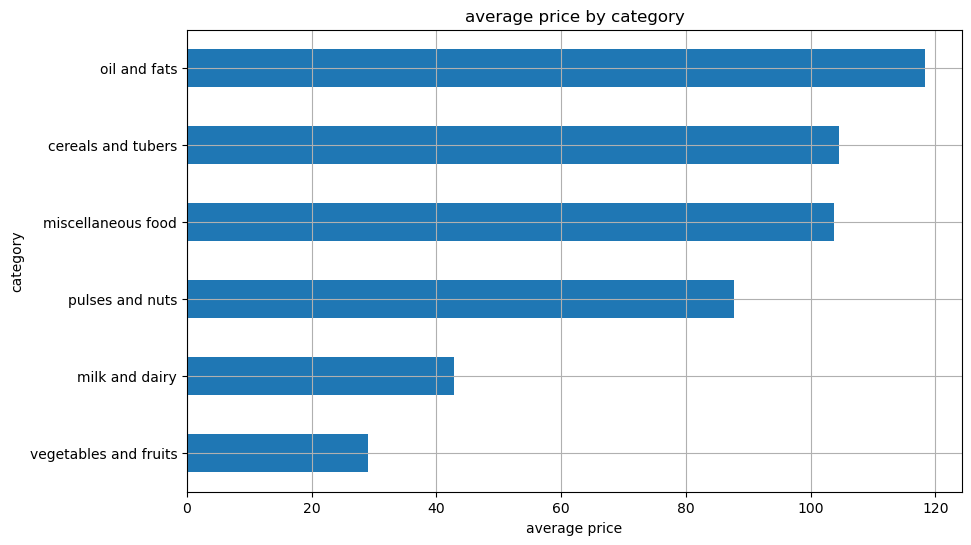

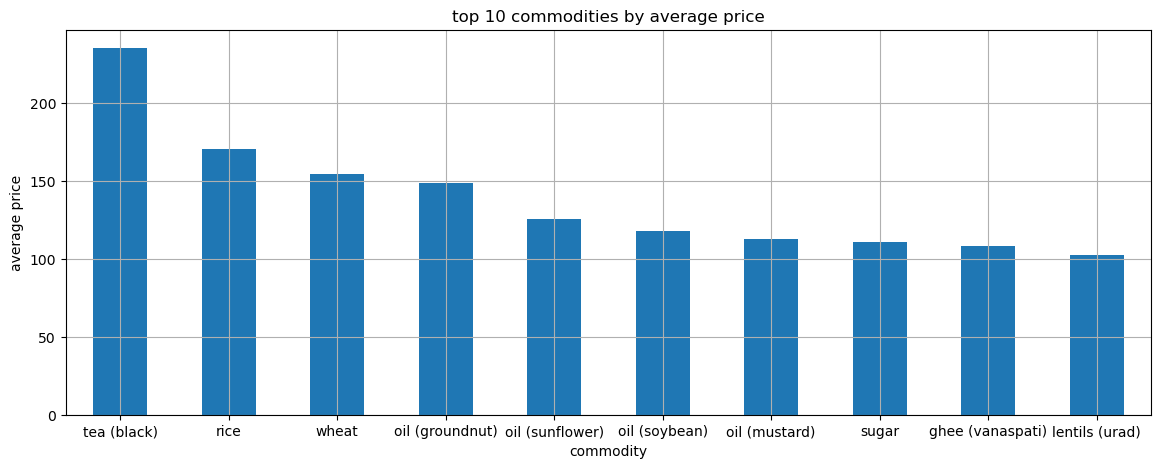

In [26]:
avg_price_by_category = df_processed.groupby('category')['price'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_price_by_category.plot(kind='barh', title="average price by category")
plt.xlabel("average price")
plt.ylabel("category")
plt.grid(True)
plt.show()

top_commodities = df_processed.groupby('commodity')['price'].mean().sort_values(ascending=False).head(10)

# Plot the top commodities
plt.figure(figsize=(14,5))
top_commodities.plot(kind='bar', title="top 10 commodities by average price")
plt.ylabel("average price")
plt.xlabel("commodity")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


In [28]:
import os

def download_processed_file(table_name, output_file):

    conn = create_connection()
    if conn is None:
        print("failed to connect to database.")
        return

    try:
        query = f"SELECT * FROM {table_name};"
        df = pd.read_sql(query, conn)
        df.to_csv(output_file, index=False)
        print(f"file saved as {output_file}")
    except Exception as e:
        logging.error(f"error downloading the file: {e}", exc_info=True)
    finally:
        conn.close()

output_file_path = "processed_food_prices.csv"

download_processed_file(processed_table_name, output_file_path)


/var/folders/7h/7928v0ks54s0w22f6bdc9cyr0000gn/T/ipykernel_1584/3415643755.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Processed file saved as processed_food_prices.csv
